# ACOL replication tensorflow

## Setup stuff

In [1]:
#imports and settings:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from jupyterthemes import jtplot
from sklearn.cluster import KMeans
from scipy.stats import threshold
#jtplot.style()
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
clustCount = 5
classCount = 2
net = 0
trainsteps = 50000
trainsteps = 5000

## Network helper functions

In [3]:
#helper funcs
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def matrix_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    return tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)

def avg_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_sum(totalSoft,2)

def max_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_max(totalSoft,2)

def initACOL(in_size,clust,clss):
    acolLayers = []
    for i in range(clss):
        acolLayers.append([
            weight_variable([in_size, clustCount]),
            bias_variable([clustCount])
        ])
    return acolLayers
        
def connectACOL(inLayer,acol):
    clust = []
    for l in range(0,len(acol)):
        clust.append(tf.matmul(inLayer, acol[l][0]) + acol[l][1])
    return clust
        
def acol(input,clust_count, class_count):
    acolLayers = []
    for i in range(class_count):
        if isinstance(input, tuple):
                input = input[0]

        #I don't know what this bit does, but I don't think it'll hurt anything
        #Or maybe it does, who knows
        input_shape = input.get_shape()
        if input_shape.ndims == 4:
            dim = 1
            for d in input_shape[1:].as_list():
                dim *= d
        #    feed_in = tf.reshape(tf.transpose(input,[0,3,1,2]), [-1, dim])
        else:
            feed_in, dim = (input, int(input_shape[-1]))

        init_weights = tf.truncated_normal_initializer(0.0, stddev=0.1)#(0.0, stddev=0.01)
        init_biases = tf.constant_initializer(1.0)#(0.1)

        weights = weight_variable([dim, clust_count])
        biases = bias_variable([clust_count])

        acoll = tf.nn.xw_plus_b(input,weights,biases)
        acolLayers.append(acol)
    return acolLayers    


## Create placeholders (weights&biases)

In [4]:
if net==0:
    #Init model weights & biases
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    y_ = tf.placeholder(tf.float32, shape=[None, classCount])

    #conv_layer1
    W_conv1 = weight_variable([5,5,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([5,5,32,64])
    b_conv2 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])

    acol = initACOL(1024,clustCount,classCount)

    #final fc layer
    W_fc2 = weight_variable([1024, classCount])
    b_fc2 = bias_variable([classCount])

### Define network

In [5]:
if net==0:
    dropout=0.3
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    l_pool1 = max_pool_2x2(l_conv1)

    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_pool1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    #fc 1
    l_pool2_flat = tf.reshape(l_pool2, [-1, 7*7*64])
    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)

    l_fc1_drop = tf.nn.dropout(l_fc1, tf.constant(dropout))

    l_acol = connectACOL(l_fc1_drop,acol)
    #l_acol = acol(l_fc1_drop,clustCount,classCount)

    #Classification layer
    stackedClusts = tf.stack(l_acol,1)
    softmaxMat = matrix_softmax(stackedClusts)
    smStacked = tf.reduce_max(softmaxMat,2)

    y_conv = smStacked

## Paper architecture

In [6]:
if net==1:
    #Init model weights & biases
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    y_ = tf.placeholder(tf.float32, shape=[None, classCount])

    #keep_prob = tf.placeholder(tf.float32)

    #conv_layer1
    W_conv1 = weight_variable([3,3,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([3,3,32,32])
    b_conv2 = bias_variable([32])

    #conv_layer3
    W_conv3 = weight_variable([3,3,32,64])
    b_conv3 = bias_variable([64])

    #conv_layer4
    W_conv4 = weight_variable([3,3,64,64])
    b_conv4 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 2048])
    b_fc1 = bias_variable([2048])

    #acol = initACOL(2048,clustCount,classCount)

In [7]:
if net==1:
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_conv1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    l_drop1 = tf.nn.dropout(l_pool2, tf.constant(0.25))

    #conv 3
    l_conv3 = tf.nn.relu(conv2d(l_drop1, W_conv3) + b_conv3)
    #conv 4
    l_conv4 = tf.nn.relu(conv2d(l_conv3, W_conv4) + b_conv4)
    l_pool4 = max_pool_2x2(l_conv4)

    l_drop2 = tf.nn.dropout(l_pool4, tf.constant(0.25))

    #fc 1
    l_pool2_flat = tf.reshape(l_drop2, [-1, 7*7*64])

    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)
    
    l_fc1_drop = tf.nn.dropout(l_fc1, tf.constant(0.5))
    
    #l_acol = connectACOL(l_fc1_drop,acol)
    l_acol = acol(l_fc1_drop,clustCount, classCount)

    #Classification layer
    stackedClusts = tf.stack(l_acol,1)
    softmaxMat = matrix_softmax(stackedClusts)
    smStacked = tf.reduce_max(softmaxMat,2)

    y_conv = smStacked

## Helperfunctions for loss

In [8]:
#helper loss funcs
def zBar(x):
    xshape = x.shape.as_list()
    print(xshape)
    s=[-1,xshape[1]*xshape[2]]
    return tf.maximum(tf.reshape(x,s),0)
    
def bigU(zb):
    return tf.matmul(tf.transpose(zb),zb)

def selectNonDiag(x):
    selection = np.ones(x.shape.as_list()[0],dtype='float32') - np.eye(x.shape.as_list()[0],dtype='float32')
    return tf.reduce_sum(tf.multiply(x,selection))

def bigV(x):
    smallNu=tf.reshape(tf.reduce_sum(x,axis=0),[1,-1])
    return tf.multiply(tf.transpose(smallNu),smallNu)

def specialNormalise(x):
    top = selectNonDiag(x)
    bottom = tf.multiply(tf.to_float(x.shape[1]-1),tf.reduce_sum(tf.multiply(x,np.eye(x.shape[1],dtype='float32'))))
    return tf.divide(top,bottom)

def frobNorm(x):
    return tf.sqrt(tf.reduce_sum(tf.square(x)))

tresh = tf.constant(0.03)
cc0=1.0
cc1=1.0
cc2=1.0
cc3=0.0003
cc4=0.000001
c0 = tf.constant(cc0)
c1 = tf.constant(cc1)
c2 = tf.constant(cc2)
c3val = tf.constant(cc3)
c3 = lambda affinity: tf.cond(tf.less(affinity,tresh),lambda: c3val,lambda: tf.constant(0.0))
c4 =tf.constant(cc4)

### Calculate loss

In [9]:
#calculate losses
#affinity
bZ = zBar(stackedClusts)#softmaxMat)
bU = bigU(bZ)
coact = selectNonDiag(bU)
affinity = specialNormalise(bU)

#balance
bV=bigV(bZ)
balance = specialNormalise(bV)

#cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), reduction_indices=[1]))

frob = frobNorm(stackedClusts)#softmaxMat)

loss = c0*cross_entropy + c1*affinity + c2*tf.subtract(tf.constant(1.0),balance) + c3(affinity)*coact + c4*frob

[None, 2, 5]


## Train network

In [10]:
lr = 1e-5
train_step = tf.train.AdamOptimizer(lr).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

In [11]:
#y = {0:[0,1], 1:[1,0]}
y = {0:[1,0,0,0,0],
     1:[1,0,0,0,0],
     2:[0,1,0,0,0],
     3:[0,1,0,0,0],
     4:[0,0,1,0,0],
     5:[0,0,1,0,0],
     6:[0,0,0,1,0],
     7:[0,0,0,1,0],
     8:[0,0,0,0,1],
     9:[0,0,0,0,1]}

y = {0:[1,0],
     1:[1,0],
     2:[1,0],
     3:[1,0],
     4:[1,0],
     5:[0,1],
     6:[0,1],
     7:[0,1],
     8:[0,1],
     9:[0,1]}

totalSteps = trainsteps
stepCount=0
batchSize = 128
hist = {
    'train_acc':[],
    'val_acc':[],
    'train_loss':[],
    'val_loss':[],
    'affinity':[],
    'balance':[],
    'coactivity':[]
}

In [12]:
for i in range(totalSteps):
    trainbatch = mnist.train.next_batch(batchSize)
    trainbatch = (trainbatch[0],np.array([y[np.argmax(trainbatch[1][j])] for j in range(len(trainbatch[1]))]))
    valbatch = mnist.validation.next_batch(batchSize)
    valbatch = (valbatch[0],np.array([y[np.argmax(valbatch[1][j])] for j in range(len(valbatch[1]))]))
    
    if i%100 == 0:
        train_loss,train_acc = sess.run([loss, accuracy],feed_dict={x: trainbatch[0], y_: trainbatch[1]})
        val_loss, val_acc = sess.run([loss, accuracy],feed_dict={x: valbatch[0], y_: valbatch[1]})
        hist['train_acc'].append(train_acc)
        hist['val_acc'].append(val_acc)
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss)
        print("step %d/%d \n Train: accuracy: %g, loss: %g \n Validation: accuracy: %g loss: %g"%(i,totalSteps, train_acc, train_loss, val_acc, val_loss))
        hist['affinity'].append(affinity.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        hist['balance'].append(balance.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        hist['coactivity'].append(coact.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        entr = cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        frb = frob.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        #print bV.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        
        print("cross_entropy: %g, affinity: %g, balance: %g, coact: %g, frob: %g"%(cc0*entr,cc1*hist['affinity'][-1],cc2*(1-hist['balance'][-1]),cc3*hist['coactivity'][-1],cc4*frb))
    feed_dict = {x: trainbatch[0], y_: trainbatch[1]}
    _ = sess.run([train_step],feed_dict=feed_dict)

step 0/5000 
 Train: accuracy: 0.523438, loss: 3.64782 
 Validation: accuracy: 0.445312 loss: 3.54265
cross_entropy: 2.66959, affinity: 0.284972, balance: 0.313616, coact: 32.1337, frob: 0.000294723
step 100/5000 
 Train: accuracy: 0.507812, loss: 2.78315 
 Validation: accuracy: 0.4375 loss: 3.58204
cross_entropy: 2.16948, affinity: 0.252573, balance: 0.0677535, coact: 15.9148, frob: 0.000223615
step 200/5000 
 Train: accuracy: 0.507812, loss: 2.49276 
 Validation: accuracy: 0.5 loss: 2.76676
cross_entropy: 2.21685, affinity: 0.238882, balance: 0.0446339, coact: 8.3471, frob: 0.000206455
step 300/5000 
 Train: accuracy: 0.625, loss: 1.69036 
 Validation: accuracy: 0.539062 loss: 2.05782
cross_entropy: 1.62759, affinity: 0.223164, balance: 0.053273, coact: 4.94416, frob: 0.000202162
step 400/5000 
 Train: accuracy: 0.632812, loss: 1.76647 
 Validation: accuracy: 0.546875 loss: 1.82102
cross_entropy: 1.4609, affinity: 0.166388, balance: 0.0376645, coact: 2.66856, frob: 0.000187018
step 5

cross_entropy: 0.376544, affinity: 0.0751423, balance: 0.0698623, coact: 0.864324, frob: 0.000191698
step 4100/5000 
 Train: accuracy: 0.890625, loss: 0.539598 
 Validation: accuracy: 0.90625 loss: 0.619931
cross_entropy: 0.436922, affinity: 0.0707913, balance: 0.0573028, coact: 0.76997, frob: 0.000193171
step 4200/5000 
 Train: accuracy: 0.890625, loss: 0.543744 
 Validation: accuracy: 0.921875 loss: 0.538215
cross_entropy: 0.407895, affinity: 0.0663122, balance: 0.0432795, coact: 0.670192, frob: 0.000191043
step 4300/5000 
 Train: accuracy: 0.90625, loss: 0.522422 
 Validation: accuracy: 0.929688 loss: 0.498998
cross_entropy: 0.437453, affinity: 0.0688368, balance: 0.0524603, coact: 0.829685, frob: 0.000197357
step 4400/5000 
 Train: accuracy: 0.898438, loss: 0.553466 
 Validation: accuracy: 0.9375 loss: 0.441386
cross_entropy: 0.34362, affinity: 0.0672928, balance: 0.0689072, coact: 0.65953, frob: 0.00018815
step 4500/5000 
 Train: accuracy: 0.890625, loss: 0.564583 
 Validation: ac

## Testing & visualising

In [13]:
testSize = 1000
testbatch = mnist.test.next_batch(testSize)
testbatch = (testbatch[0],np.array([y[np.argmax(testbatch[1][j])] for j in range(len(testbatch[1]))]))

test_loss,test_acc = sess.run([loss,accuracy],{x: testbatch[0], y_: testbatch[1]})
print('Test: accuracy: %g, loss: %g'%(test_acc,test_loss))

Test: accuracy: 0.895, loss: 0.557811


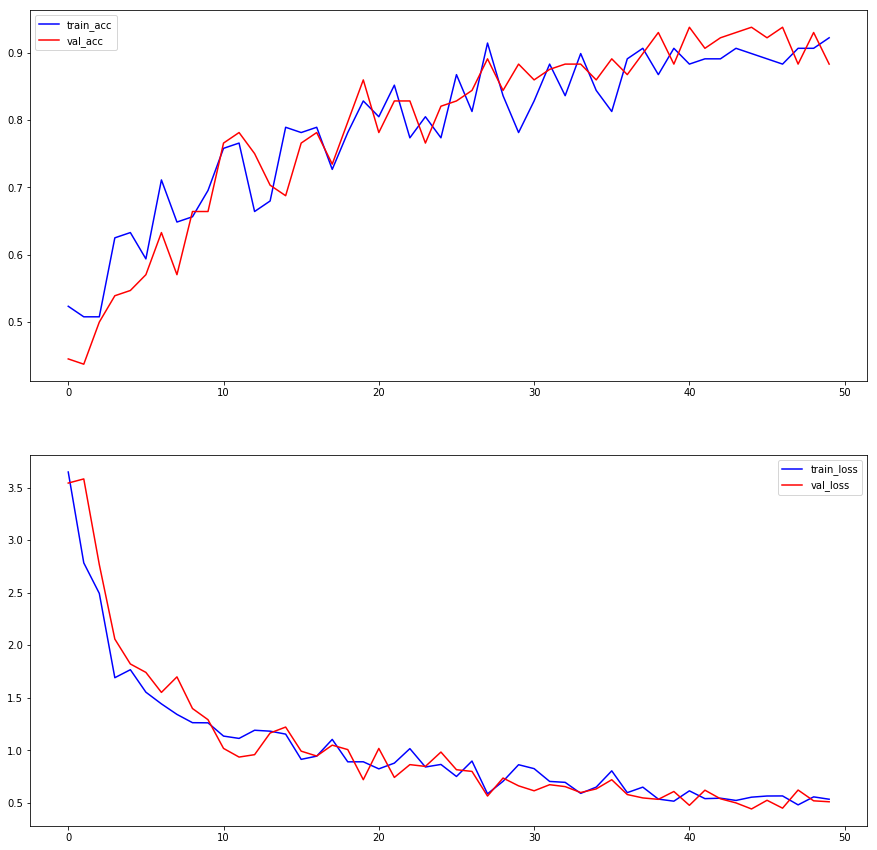

In [14]:
#Plot accuracy and loss
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.plot(hist['train_acc'],'-b',label='train_acc')
plt.plot(hist['val_acc'],'-r',label='val_acc')
plt.legend()
plt.subplot(212)
plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['val_loss'],'-r',label='val_loss')
plt.legend()

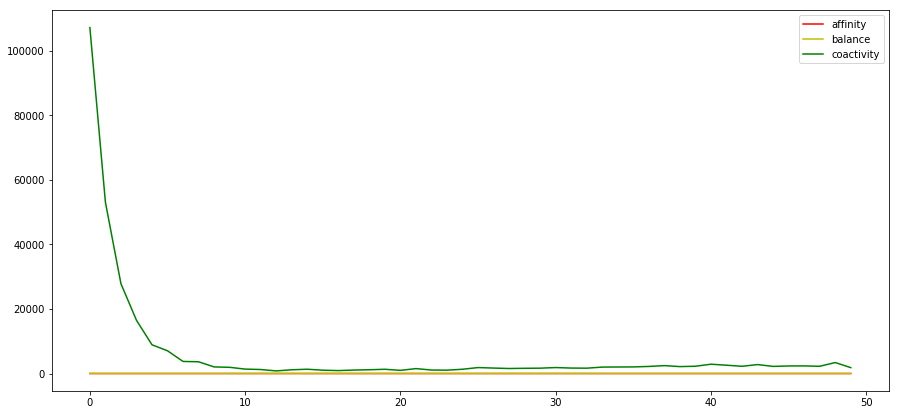

In [15]:
plt.figure(figsize=(15,7))
#plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['affinity'],'-r',label='affinity')
plt.plot(np.subtract(1,hist['balance']),'-y',label='balance')
plt.plot(hist['coactivity'],'-g',label='coactivity')
plt.legend()

In [32]:
digitTrace = np.zeros((classCount*clustCount,784))
digitTraceCount = np.zeros((classCount*clustCount))
digitCount = np.zeros(10)

In [50]:
#sess.run(tf.global_variables_initializer())
for i in range(1000):
    tb = mnist.test.next_batch(1)
    digitCount[np.argmax(tb[1])]+=1
    testbatch = (tb[0],np.array([y[np.argmax(tb[1][j])] for j in range(len(tb[1]))]))
    smMat, acc = sess.run([softmaxMat,accuracy],feed_dict={x: testbatch[0], y_: testbatch[1]})
    ypred = softmaxMat.eval({x: testbatch[0], y_: testbatch[1]})
    digitTrace[np.argmax(ypred),:] += tb[0].ravel()
    digitTraceCount[np.argmax(ypred)] += 1

In [51]:
print(digitCount)
print(digitTraceCount)

[ 113.  127.  113.  118.  109.  107.  108.  125.  102.  104.]
[  74.  137.  111.   95.  147.  111.  147.   85.  104.  101.]


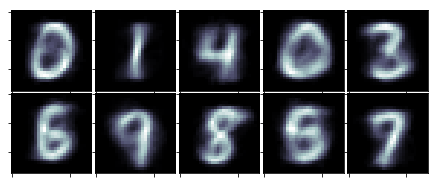

In [52]:
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')

In [53]:
stepCount = len(hist['train_acc'])*100
with open('./trainlog.txt','ab') as f:
    f.write('lr: %g, batchsize: %i, steps: %i, thresh: %g, c1: %g, c2: %g, c3: %g, c4: %g, test_acc: %g, test_loss: %g\n'%
            (lr,batchSize,stepCount,tresh.eval(), cc1, cc2, cc3, cc4, test_acc, test_loss))

TypeError: a bytes-like object is required, not 'str'

## Clustering score

In [ ]:
tb = mnist.test.next_batch(10000)
#tb[0][:,:] = threshold(tb[0][:,:],threshmin=0.5,newval=0)
#tb[0][:,:] = threshold(tb[0][:,:],threshmax=0.49,newval=1)
testbatch = (tb[0],np.array([y[np.argmax(tb[1][j])>4] for j in range(len(tb[1]))]))
testFeed = {x: testbatch[0], y_: testbatch[1]}
ypred = softmaxMat.eval(testFeed)
ypred = ypred.reshape((tb[0].shape[0],clustCount*classCount))
ypred = tf.argmax(ypred,1).eval()
ylookup = [np.argmax(np.sum(tb[1][ypred==i],0)).astype('int32') for i in range(clustCount*classCount)]
yconverted = [ylookup[i] for i in ypred]
correct_prediction = tf.equal(yconverted, np.argmax(tb[1],1).astype('int32'))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).eval()
print 'Clustering Accuracy: %g'%(accuracy)
print ylookup

## Compare it to k-means

In [ ]:
tb0 = [tb[0][np.argmax(tb[1],1)<5],tb[1][np.argmax(tb[1],1)<5]]
tb1 = [tb[0][np.argmax(tb[1],1)>4],tb[1][np.argmax(tb[1],1)>4]]
#<5
kmeans = KMeans(n_clusters=5)
km0_ypred = kmeans.fit_transform(tb0[0])
km0_ypred = np.argmax(km0_ypred,1)
km_ylookup = [np.argmax(np.sum(tb0[1][km0_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km0_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb0[1],1).astype('int32'))
km0_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
#>4
kmeans = KMeans(n_clusters=5)
km1_ypred = kmeans.fit_transform(tb1[0])
km1_ypred = np.argmax(km1_ypred,1)
km_ylookup = [np.argmax(np.sum(tb1[1][km1_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km1_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb1[1],1).astype('int32'))
km1_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
print 'ACOL Accuracy: %g'%(accuracy)
print 'KMeans Accuracy: %g'%((km0_accuracy+km1_accuracy)/2)

In [ ]:
#visualise kmeans
digitTrace = np.concatenate([[np.sum(tb0[0][km0_ypred==i,:],axis=0) for i in range(clustCount)],
                       [np.sum(tb1[0][km1_ypred==i,:],axis=0) for i in range(clustCount)]])
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')